# Predicting the group name for terrorism dataset employing deep learning in Keras. 

### Here we build a nueral network in Keras. We build two models. In one we build a sequential model using only numerical and categorical features (no text features). In another model we use all features (text, numbers and categories). We use Keras Functional API to build a network with three inputs. Two embedding layers for text features and one dense layer for numerical features. 
### We build a new summary column by combining the summary and scite1 column and feed that as one input. For this input we use the embedding layer from keras and employ Pre-Trained GloVe Embedding.
### For textual categorical features (e.g. city, targsubtype1_txt, etc)  we use one-hot encoder at the embedding layer.
### Numerical features are imputed using fancyimpute.

For details of pre-trained GloVe look at: https://nlp.stanford.edu/projects/glove/

For more details on keras functional API which covers the multiple input model look at: https://machinelearningmastery.com/keras-functional-api-deep-learning/

For more details on embedding layer in keras look at: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/


In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.sparse import save_npz,load_npz
from scipy.stats import norm
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline, make_union,Pipeline,FeatureUnion
from sklearn.preprocessing import FunctionTransformer,LabelEncoder,LabelBinarizer,StandardScaler,Imputer
from sklearn.cross_validation import cross_val_score
from keras.utils import np_utils
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.externals import joblib
from sklearn.ensemble import VotingClassifier
from sklearn_pandas import DataFrameMapper
from geopy.geocoders import Nominatim
import reverse_geocoder as rg
import requests
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import nltk
import string 
from utils import *
import fancyimpute 
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, MICE
from keras.preprocessing.text import Tokenizer,one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout,Input
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.layers.merge import concatenate
from keras.wrappers.scikit_learn import KerasClassifier

#init_notebook_mode()
%matplotlib inline

nltk.download('punkt')
nltk.download('stopwords')
stemmer = SnowballStemmer("english")
pd.options.mode.chained_assignment = None
pd.set_option('max_info_columns', 200)
pd.options.display.float_format = '{:,.2f}'.format


/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/rahmani/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[nltk_data] Downloading package punkt to /home/rahmani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rahmani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import data. Since many data points are systematically available with incidents occurring after 1997 we only use the data collected after 1997 (look at the codebook).

In [2]:
terrorism = pd.read_csv('terrorist_data.csv')
dff = terrorism[terrorism.iyear >= 1998]
dff.reset_index(drop=True,inplace=True)

/home/rahmani/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4,6,31,33,53,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Fill unknown cities using latitude and longitude.

In [3]:
# this needs internet connection and doesn't work for all values
latlng = dff.loc[dff['city'].isnull()].apply(lambda row: '{},{}'.format(row['latitude'], row['longitude']), axis=1)
geocode = latlng.map(reverse_geocode)
dff.loc[geocode.index,('city')] = geocode.map(parse_city)
dff.loc[dff['city'].isnull()][['longitude','latitude']].loc[~dff['longitude'].isnull()]
def city_finder(x):
    coordinates = (x['longitude'],x['latitude'])
    results = dict(rg.search(coordinates)[0])
    return(results['name'])
    
city = dff.loc[dff['city'].isnull()][['longitude','latitude']].loc[~dff['longitude'].isnull()].apply(city_finder,axis=1)
dff.loc[city.index,'city'] = city.values

Loading formatted geocoded file...


#### Remove features with more than 20% missing values and removing some features that are not usefull such as eventid, etc.

In [4]:
# Remove features with more than 20% missing values
feature_null_counts = dff.apply(lambda col: col.isnull().sum(), axis=0)
num_rows = len(dff)
features = feature_null_counts[feature_null_counts < (0.2 * num_rows)].index.difference(['gname'])
# Exclude features that are Text (these end with _txt)
# features = features[~features.str.endswith("_txt")]
features = list(features)+['gname']
# remove longitude and latitude since we have city and country. Remove eventid because it is not useful. 
features = [x for x in features if x not in ['eventid','latitude','longitude']]
dff = dff[features]
len(features)

54

### Defining feature types.

In [5]:
text_features = ['provstate','summary','target1']

number_features = ['nperpcap', 'nkill', 'nkillus', 'nkillter', 'nwound', 'nwoundus', 'nwoundte']

binary_features = ['INT_MISC','claimed', 'crit1', 
                    'crit2', 'crit3', 'doubtterr','extended', 
                    'guncertain1','individual','ishostkid', 
                    'multiple','property', 
                    'success', 'suicide', 
                    'vicinity']

range_features_txt = ['city','dbsource','corp1',
                     'attacktype1_txt','country_txt','region_txt',
                     'targsubtype1_txt', 'targtype1_txt', 
                    'weapsubtype1_txt', 'weaptype1_txt','natlty1_txt']

range_features_txt_dummy = ['dbsource','attacktype1_txt','country_txt','region_txt',
                     'targsubtype1_txt', 'targtype1_txt', 
                    'weapsubtype1_txt', 'weaptype1_txt','natlty1_txt']

range_features_numeric = ['iday','imonth','iyear', 'specificity']


### Replace -9 and -99 in number features with nan (to impute later). Impute nan in binary features with -9 (corresponding to unknown). Impute nan in range features with 'missing' or 0 for texts and number, respectively.

In [6]:
for col in number_features:
    dff[col].loc[(dff[col]==-9) | (dff[col]==-99)] = np.nan
    
for col in binary_features:
    dff[col].loc[dff[col]==-99] = -9
    dff[col].loc[dff[col].isnull()] = -9

for col in range_features_txt:
    dff[col].loc[dff[col].isnull()] = 'missing'

for col in range_features_numeric:
    dff[col].loc[dff[col].isnull()] = 0


### Stemming

In [7]:
# combine summary and scite1
dff['summary'] = dff['summary'].apply(lambda x:str(x)) + ' ' + dff['scite1'].apply(lambda x:str(x))
# First we stem the words in the summary, remove punctuations, numbers, stopwords and white spaces. 
# we also remove word "al" ("al" means "the" in arabic).
print('First original summery: ',dff.summary.iloc[0])
print(' ')
dff.summary = dff.summary.apply(lambda x:word_tokenize(x)).apply(lambda x:' '.join(list(map(stemmer.stem,x)))) # stemming, this takes couple of minutes
dff.summary = dff.summary.apply(lambda x:text2int(x))  # convert text numbers to digits
table = str.maketrans("","",string.punctuation+'”'+'“')
stops = set(stopwords.words("english") + ['al']) 
pat = r'\b(?:{})\b'.format('|'.join(stops))
for col in range_features_txt + text_features : 
    dff[col] = dff[col].str.translate(table)    # remove punctuation
    dff[col] = dff[col].str.replace(pat,'')                # remove stopwords and "al"
    dff[col] = dff[col].str.replace('\d+','')             # remove numbers
    dff[col] = dff[col].str.replace(r'\s+', ' ')          # remove white spaces
    dff[col] = dff[col].str.strip()                       # remove whitespaces
print('Firt summary after stemming: ',dff.summary.iloc[0])

First original summery:  01/01/1998: Hutu Rebels attacked a Burundi military target at Bujumbura Airport. The attack resulted in 104 fatalities, including 100 perpetrators, and six injuries. “Burundi Rebels, Ex-Rwandan Army Soldiers Blamed For Attack,” Bujumbura Radio-Television Nationale du Burundi Radio in French, January 01, 1998.
 
Firt summary after stemming:  hutu rebel attack burundi militari target bujumbura airport attack result fatal includ perpetr injuri burundi rebel ex rwandan armi soldier blame attack bujumbura radio televis national du burundi radio french januari


In [8]:
# add a feature for number features that if they are null it is 1 and 0 otherwise
for d in number_features:
    dff[d+'_isknown'] = dff[d].isnull()*1
    binary_features.append(d+'_isknown')

### Imputing numerical features using MICE algorithm from fancy impute.
https://github.com/iskandr/fancyimpute

In [9]:
def numeric_fill(df,fill_values):
    numerical_features = ['nperpcap', 'nkill', 'nkillus', 'nkillter', 'nwound', 'nwoundus', 'nwoundte']

    imputer = Imputer()
    x = imputer.fit_transform(df[numerical_features])
    x = pd.DataFrame(x,columns = df[numerical_features].columns,index=df.index)
    x = x.loc[df.index[df[numerical_features].isnull().all(1)]] 
    df = df.combine_first(x)

# softimpute 
#    biscaler = BiScaler(verbose=False)
#    X_incomplete_normalized = biscaler.fit_transform(df[numerical_features].values)
#    X_filled_softimpute_normalized = SoftImpute(verbose=False).complete(X_incomplete_normalized)
#    X_filled_softimpute =biscaler.inverse_transform(\
#                           X_filled_softimpute_normalized)
#    X_filled_softimpute = pd.DataFrame(X_filled_softimpute,columns=numerical_features,index=df[numerical_features].index)
#    df = df.combine_first(X_filled_softimpute)

# MICE impute
    mice = MICE(n_imputations=5, impute_type='pmm',verbose=False)
    X_completed = mice.complete(df[numerical_features].values)
    X_completed = pd.DataFrame(X_completed,columns=numerical_features,index=df[numerical_features].index)
    df = df.combine_first(X_completed)
    return df



In [10]:
# impute nan in text features by empty
def get_feature_text(col):
    def get_text(df):
        return df[col].fillna("")    
    return get_text

all_features = number_features + binary_features + range_features_txt + range_features_numeric + text_features

In [11]:
# perform the imputation on numerical features
dg = dff[number_features]
dg = numeric_fill(dg,{})
dff = dff.combine_first(dg)

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [12]:
# merging some range features, to use as one of the inputs of the network.  
dff['range_txt'] = ' '
for col in ['target1','provstate','city','corp1']:
    dff['range_txt'] = dff['range_txt'] + ' ' + dff[col].apply(lambda x:str(x))

### Plot histogram for the length of some of features that we want to binarize.

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


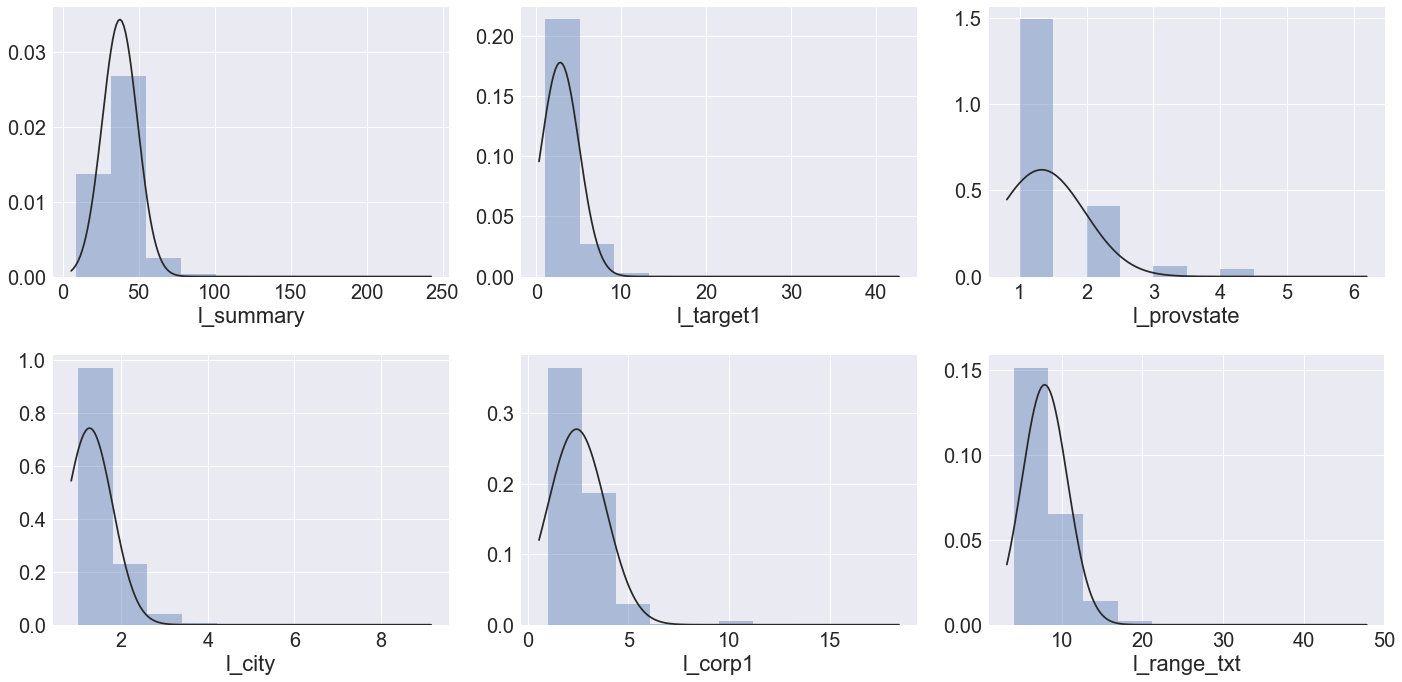

In [13]:
sns.set(font_scale=2)
fig = plt.figure()
for i,col in enumerate(['summary','target1',
                       'provstate','city','corp1','range_txt']):
    ax = fig.add_subplot(2,3,i+1)
    dff['l_'+col] = dff[col].apply(lambda x: len(str(x).split()))
    sns.distplot(dff['l_'+col].dropna(),kde=False,fit=norm, bins=10,ax=ax)

fig.set_size_inches(20,10)
plt.tight_layout()
# dff['l_summary'] = dff['summary'].apply(lambda x: len(str(x).split()))
# sns.distplot(dff['l_summary'])

## Embed summary column using pre-trained GloVe embedding.

In [14]:
# define tokenizer
t = Tokenizer()
t.fit_on_texts(dff.summary)
vocab_size1 = len(t.word_index) + 1
# encode the summary
encoded_docs1 = t.texts_to_sequences(dff.summary)
# pad summeries to a max length of 100 (look at the plot above)
max_length1 = 100
padded_docs1 = pad_sequences(encoded_docs1, maxlen=max_length1, padding='post')
# load the whole embedding into memory
embeddings_index = dict()
# load the pre-trained embedding
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size1, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.


In [15]:
print('number of unique words in range_txt: ',len(dff.range_txt.str.split(expand=True).stack().value_counts()))

number of unique words in range_txt:  59217


### Encoding and padding the range_txt column.

In [16]:
# integer encode the documents
vocab_size2 = 60000
encoded_docs2 = [one_hot(d, vocab_size2) for d in dff.range_txt]

# pad documents to a max length of words
max_length2 = 20
padded_docs2 = pad_sequences(encoded_docs2, maxlen=max_length2, padding='post')
print(padded_docs2.shape)

(102914, 20)


In [17]:
# save the data frame.
dff.to_pickle('dff_deep.p')

In [18]:
dff = pd.read_pickle('dff_deep.p')

In [19]:
# keep the data points with groups that the number of their attacks is more than a threshold. 
# create the new dataframe containing attacks with unknown groups.
threshold = 2
dff['gcount'] = dff.groupby(['gname'])['gname'].transform('count')
dff_nogname = dff.loc[dff.gname == 'Unknown']
padded_docs1_new = padded_docs1[dff.loc[dff.gname == 'Unknown'].index.values]
padded_docs1 = padded_docs1[dff.loc[dff.gname != 'Unknown'].index.values]
padded_docs2_new = padded_docs2[dff.loc[dff.gname == 'Unknown'].index.values]
padded_docs2 = padded_docs2[dff.loc[dff.gname != 'Unknown'].index.values]
dff = dff.loc[dff.gname != 'Unknown']
dff.reset_index(drop=True,inplace=True)
padded_docs2 = padded_docs2[dff.loc[dff.gcount>threshold].index.values]
padded_docs1 = padded_docs1[dff.loc[dff.gcount>threshold].index.values]
dff = dff[dff.gcount>threshold]

if threshold <30:
    epochs1 = 250
    epochs2 = 30
elif threshold >=30:
    epochs1 = 150
    epochs2 = 20
print("number of unique gnames:",dff.gname.unique().size)
print("number of unique gnames:",dff_nogname.gname.unique().size) # only one: "unkown"

number of unique gnames: 624
number of unique gnames: 1


In [20]:
# Binarizing the remaining range and binary features.
mapper = DataFrameMapper(
  [(continuous_col, LabelBinarizer()) for continuous_col in range_features_txt_dummy + range_features_numeric]
 +[(continuous_col, LabelBinarizer()) for continuous_col in binary_features]    
 +[(nomap_col, None) for nomap_col in number_features]   
)

union =  Pipeline([("mapper", mapper)])

Y = dff.gname.copy()

encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(Y)
y = np_utils.to_categorical(encoded_Y)

# split the dataset to train and test.
X_train, X_test, y_train, y_test,encoded_Y_train,encoded_Y_test,p_train1,p_test1,p_train2,p_test2 = train_test_split(dff[all_features],\
                                                                   y,\
                                                                   encoded_Y,\
                                                                   padded_docs1,\
                                                                   padded_docs2,\
                                                                   test_size = 0.3,\
                                                                   random_state = 15)
# pipeline
X_train_dtm = union.fit_transform(X_train)
X_test_dtm = union.transform(X_test)
x_new_dtm = union.transform(dff_nogname)

# Encode the target feature
# encode class values as integers
#encoder = LabelEncoder()
#encoded_Y = encoder.fit_transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
#y_train = np_utils.to_categorical(encoded_Y)
#encoded_Y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
#y_test = np_utils.to_categorical(encoded_Y_test)

assert(X_train_dtm.shape[1]==X_test_dtm.shape[1] and X_train_dtm.shape[1]==x_new_dtm.shape[1])

### First we build a model using only numerical and categorical features (no text feature). This is a sequntial model and ReLu and Tanh activation is used at hidden layer. Softmax activation is employed at output.
### Build the network.

### We use the adam optimizer and categorical cross entropy for the loss function.

In [21]:
def baseline_model_notxt(input_dim=None,output_dim=None):
    model = Sequential()
    model.add(Dense(256,input_dim=input_dim,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256,activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128,activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=output_dim,activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return model

model = KerasClassifier(build_fn=baseline_model_notxt,input_dim=X_train_dtm.shape[1],output_dim=y_train.shape[1],epochs=epochs1,batch_size=2500,verbose=0)

#model.fit(x = [p_train1,p_train2,X_train_dtm], y=y_train) 
model.fit(x = X_train_dtm, y=y_train)

### Print  infromation about the accuracy of the model.

In [22]:
y_pred_train = model.predict([X_train_dtm])
y_pred_test = model.predict([X_test_dtm])
print('Train score = %.3f' % (100*metrics.accuracy_score(encoded_Y_train, y_pred_train)))
print_precision_recall(encoded_Y_test,y_pred_test)

Train score = 97.773
Test score = 76.673
Average precision =  75.079
Average recall =  76.673
Average fscore =  75.047
Total support =  14048


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1140: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1142: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Even with using dropout regularization at each layer, still there is a large difference between train and test score which is a sign of overfitting. Now lets add text features to the model and compare the results.

### Now we build a multi input model using all features. After each input layer we use one layer with ReLu activation and Tanh activation. At the output layer we use a softmax activation.

### We use the adam optimizer and categorical cross entropy for the loss function.

In [23]:
def baseline_model_txt(shape3=None,output_dim3=None):
    visible1 = Input(shape=(max_length1,))
    embed1 = Embedding(vocab_size1, 100,weights=[embedding_matrix], input_length=max_length1,trainable=False)(visible1)
    flat1 = Flatten()(embed1)
    dense1 = Dense(256,activation='relu')(flat1)
    dense2 = Dense(256,activation='tanh')(dense1)

    visible2 = Input(shape=(max_length2,))
    embed2 = Embedding(vocab_size2, 100, input_length=max_length2)(visible2)
    flat2 = Flatten()(embed2)
    dense3 = Dense(256,activation='relu')(flat2)
    dense4 = Dense(256,activation='tanh')(dense3)    
    (X_train_dtm.shape[1],)
    visible3 = Input(shape=shape3)
    class1 = Dense(256,activation='relu')(visible3)
    class2 = Dense(256,activation='tanh')(class1)

    
    merge = concatenate([dense2,dense4,class2])
    hidden1 = Dense(256,activation='relu')(merge)
    hidden2 = Dense(256,activation='tanh')(hidden1)
    output = Dense(units=output_dim3,activation='softmax')(hidden2)
    model = Model(inputs=[visible1,visible2,visible3],outputs=output)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return model

model = KerasClassifier(build_fn=baseline_model_txt,shape3=(X_train_dtm.shape[1],),output_dim3=y_train.shape[1],epochs=epochs2,batch_size=2500,verbose=0)

#model.fit(x = [p_train1,p_train2,X_train_dtm], y=y_train) 
model.fit(x = [p_train1,p_train2,X_train_dtm], y=y_train)

In [24]:
y_pred_train = model.predict([p_train1,p_train2,X_train_dtm])
y_pred_test = model.predict([p_test1,p_test2,X_test_dtm])
print('Train score = %.3f' % (100*metrics.accuracy_score(encoded_Y_train, y_pred_train)))
print_precision_recall(encoded_Y_test,y_pred_test)

Train score = 100.000
Test score = 82.239
Average precision =  79.864
Average recall =  82.239
Average fscore =  80.366
Total support =  14048


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1140: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1142: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# There is about 10% increase in score, precision and recall when we use both text features and numerical features. Also the overfitting is reduced significantly.

### Making predictions for the data points with missing group name.

In [25]:
# predict
y_new_pred = model.predict([padded_docs1_new,padded_docs2_new,x_new_dtm])

# inverse transform to get the group name
print(encoder.inverse_transform(y_new_pred))

['Chechen Rebels' 'Islamic State of Iraq and the Levant (ISIL)'
 'Palestinian Extremists' ... 'Taliban' "New People's Army (NPA)"
 'Anarchists']
